# Earlier Pre-processing

In [68]:
DATA_PATH = Path('../../data/interim')
df = pd.read_csv(DATA_PATH/'train_valid_data.csv', low_memory=False)
df.head()

,store,state,date,max_temperature_c,mean_temperature_c,min_temperature_c,dew_point_c,mean_dew_point_c,min_dew_point_c,max_humidity,...,promo_interval,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,trend,week_start
0,1,HE,2013-01-01,8,6,3,6,3,1,93,...,None,1,0.0,0.0,0.0,0.0,a,1.0,61,2012-12-30
1,56,HE,2013-01-01,8,6,3,6,3,1,93,...,"Mar,Jun,Sept,Dec",1,0.0,0.0,0.0,0.0,a,1.0,61,2012-12-30
2,69,HE,2013-01-01,8,6,3,6,3,1,93,...,"Jan,Apr,Jul,Oct",1,0.0,0.0,0.0,0.0,a,1.0,61,2012-12-30
3,77,HE,2013-01-01,8,6,3,6,3,1,93,...,"Jan,Apr,Jul,Oct",1,0.0,0.0,0.0,0.0,a,1.0,61,2012-12-30
4,111,HE,2013-01-01,8,6,3,6,3,1,93,...,"Jan,Apr,Jul,Oct",1,0.0,0.0,0.0,0.0,a,1.0,61,2012-12-30


In [ ]:
df.dtypes[df.dtypes == 'object']
# state, events, store_type, assortment, promo_interval, state_holiday
# date we can skip because we'll use add_datepart() on that, and it will get turned into datetime (and many other things)
# week_start we can delete as that will get taken into account by add_datepart() for date

In [ ]:
#Date calculations to ensure we get the correct dataframes for testing and for training/validation
#df.date.min() # 2013-01-01
#df.date.max() # 2015-07-31
#pd.to_datetime('2015-07-31').dayofweek # 4 = Friday
#pd.to_datetime('2015-07-31').week # 31
#pd.to_datetime('2015-06-19').dayofweek # 4
#pd.to_datetime('2015-06-19').week # 25
#pd.to_timedelta(pd.to_datetime('2015-07-31') - pd.to_datetime('2015-06-19'))
#test_data = df.loc[df.date >= '2015-06-20'].copy()
#len(test_data) # 46830
#len(test_data)/1115 # 42 days
#train_valid_data = df.loc[df.date <= '2015-06-19'].copy()
#len(train_valid_data) # 1003500
#len(train_valid_data)/1115 # 900 days

In [ ]:
# Figure out how big the validation set should be
#len(train_valid_data) # 1,003,500
#len(train_valid_data) * .2 # 200,700
#len(train_valid_data) * .2 / 1115 # 180 days = 20% of the train_valid_data set

In [ ]:
test_data.to_csv('../../data/interim/test_data.csv', index=False)
print('did test')
train_valid_data.to_csv('../../data/interim/train_valid_data.csv', index=False)
print('did train')

# Imports

In [83]:
import contextlib
from datetime import datetime
from fastai import *
from fastai.tabular import *
import io
import pandas as pd
from pathlib import Path

# Get Data

In [17]:
DATA_PATH = Path('../../data/interim')
#path = Path('../../data/interim')
path = Path('../../data/interim')

In [190]:
# Import train_valid_data and test_data dataframes
train_valid_df_raw = pd.read_csv(DATA_PATH/'train_valid_data.csv', low_memory=False)
test_df_raw = pd.read_csv(DATA_PATH/'test_data.csv', low_memory=False)

train_valid_df = train_valid_df_raw.copy()
test_df = test_df_raw.copy()

# Drop week_start as that will get taken into account by add_datepart() for date
train_valid_df.drop('week_start', axis='columns', inplace=True)
test_df.drop('week_start', axis='columns', inplace=True)

# Drop any rows where sales = 0 since we're using rmspe
train_valid_df = train_valid_df[train_valid_df.sales != 0]

# Run tabular.add_datepart() on both dfs to add columns about the date: ['Year', 'Month', 'Week', 'Day', 'Dayofweek',
# 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
tabular.add_datepart(train_valid_df, 'date', drop=True, time=False)
tabular.add_datepart(test_df, 'date', drop=True, time=False)

# Category names, to which we'll apply embeddings
cat_names = ['assortment', 'events', 'promo_interval', 'state', 'state_holiday', 'store_type']

# Add the date-related categories -- check this later EDIT
cat_names += ['Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
              'Is_year_start', 'Month', 'Week', 'Year',]

# Continuous-variable names, which we'll make sure are all represented as floats
# Just use set difference to make sure everything is covered
cont_names = list(set(train_valid_df.columns) - set(cat_names))

# Set up transforms to 1) replace missing values for continuous variables by the median column value, 2) transform all
# categorical variables into categories, 3) normalize continuous variables.
# Note that FillMissing should do nothing since we shouldn't have any NaNs -- leaving it in anyway
procs = [FillMissing, Categorify, Normalize]

df = train_valid_df
#valid_idx = range(len(df)-200700, len(df))
dep_var = 'sales'

data = (TabularList.from_df(df, path=DATA_PATH, cat_names=cat_names, cont_names=cont_names, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   .databunch())

data.show_batch(ds_type=DatasetType.Train)

Exception: Your data isn't split, if you don't want a validation set, please use `no_split`

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


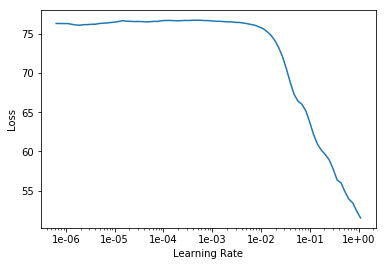

In [5]:
#emb_szs = {'assortment': 2, 'events': 11, 'promo_interval': 2, 'state': 6, 'state_holiday': 2, 'store_type': 2} 

#learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
#                        y_range=y_range, metrics=exp_rmspe)

learn = tabular_learner(data, layers=[200, 100], ps=[0.001, 0.01], emb_drop=0.04, metrics=exp_rmspe)
learn.lr_find()
learn.recorder.plot()
#learn.fit_one_cycle(cyc_len=5, max_lr=1e-3)

In [9]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,0.025480,0.003842,0.049402
2,0.014110,0.001625,0.037231
3,0.013825,0.001252,0.033372
4,0.012304,0.003085,0.053314
5,0.012051,0.000852,0.027315


In [10]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.011292,0.001311,0.032546
2,0.011370,0.000370,0.017435
3,0.011201,0.000197,0.012425
4,0.010744,0.000703,0.024696
5,0.010977,0.001184,0.031148


In [8]:
learn.fit_one_cycle(cyc_len=3, max_lr=1e-2)

epoch,train_loss,valid_loss,exp_rmspe
1,0.025586,890.502991,inf
2,0.016230,408265.562500,inf
3,0.011620,21729.226562,inf


In [9]:
learn.fit_one_cycle(cyc_len=5, max_lr=5e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,0.016308,7737.904297,inf
2,0.015016,1.098974,inf


KeyboardInterrupt: 

In [10]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,0.011023,2.388310,inf
2,0.010656,0.246039,inf
3,0.011150,3.579773,inf
4,0.010434,0.320079,4981867.000000
5,0.010305,0.571406,906.485718


### After restart

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


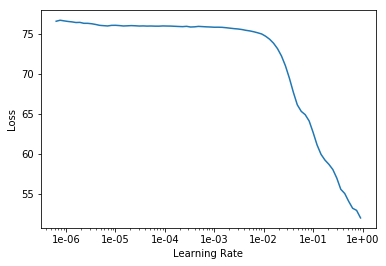

In [4]:
learn = tabular_learner(data, layers=[200, 100], ps=[0.001, 0.01], emb_drop=0.04, metrics=exp_rmspe)
learn.lr_find()
learn.recorder.plot()

In [5]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,0.026064,0.003661,0.055782
2,0.014733,0.002478,0.047420
3,0.012904,0.001935,0.041950
4,0.011737,0.001385,0.035558
5,0.010864,0.001459,0.036004


In [6]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,0.012952,0.002830,0.037617
2,0.012350,0.105415,0.059411
3,0.012184,0.101754,1891128320.000000
4,0.010262,0.175492,inf
5,0.010423,0.722614,inf


In [7]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.010567,0.844973,inf
2,0.009605,0.432837,inf
3,0.009868,0.444940,inf
4,0.010251,0.676773,inf
5,0.010014,1.042304,inf


In [8]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-5)

epoch,train_loss,valid_loss,exp_rmspe
1,0.009899,0.124299,1274636795904.000000
2,0.009756,0.611551,inf
3,0.010502,0.513502,inf
4,0.009416,0.427449,inf
5,0.009692,0.485360,inf


In [9]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.010008,1.044715,inf
2,0.009200,0.772075,inf
3,0.009577,0.448927,inf
4,0.009640,0.483685,inf
5,0.009884,0.080493,121840.234375


In [10]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.010828,0.294285,inf
2,0.012172,0.566598,inf
3,0.010087,0.684557,inf
4,0.010330,0.670010,inf
5,0.009537,0.868025,inf


In [11]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=5, max_lr=1e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.010905,0.366323,inf
2,0.010595,0.774839,inf
3,0.010338,0.858998,inf
4,0.009412,0.449346,inf
5,0.009319,1.277176,inf


In [12]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=5, max_lr=1e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.009863,0.447188,inf
2,0.010250,0.558749,inf
3,0.010974,0.100403,19035973632.000000
4,0.009623,1.177095,inf
5,0.010441,0.329295,inf


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


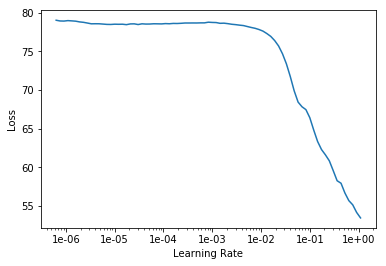

In [13]:
learn = tabular_learner(data, layers=[200, 100], ps=[0.01, 0.1], emb_drop=0.5, metrics=exp_rmspe)
learn.lr_find()
learn.recorder.plot()

In [14]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=5, max_lr=1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,0.098120,0.005683,0.070427
2,0.065269,0.003645,0.057875
3,0.052688,0.002228,0.044542
4,0.047726,0.002468,0.027342
5,0.046278,0.002084,0.043489


In [15]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=4, max_lr=1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,0.044391,0.006290,0.076575
2,0.037517,0.082012,inf
3,0.034288,0.419582,inf
4,0.031725,0.464722,inf


In [16]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=5, max_lr=1e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.029797,1.384853,inf
2,0.031261,2.140777,inf
3,0.029857,2.296008,inf
4,0.030639,2.562731,inf
5,0.029259,2.343984,inf


In [18]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=5, max_lr=1e-5)

epoch,train_loss,valid_loss,exp_rmspe
1,0.030058,0.815099,inf
2,0.029788,0.003767,1.349626
3,0.030781,2.096146,inf
4,0.028828,2.555069,inf
5,0.030394,2.101927,inf


In [19]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=5, max_lr=1e-6)

epoch,train_loss,valid_loss,exp_rmspe
1,0.029524,1.464264,inf
2,0.030197,1.676348,inf
3,0.029444,1.558804,inf
4,0.029590,2.809521,inf
5,0.030390,1.000834,inf


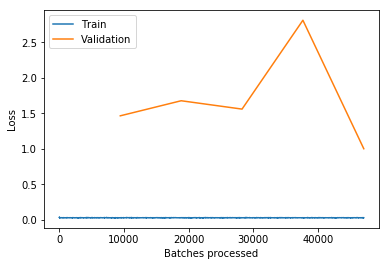

In [20]:
learn.recorder.plot_losses()

In [21]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=15, max_lr=1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,0.030815,1.210659,inf
2,0.030097,0.770582,inf
3,0.026930,0.742203,inf
4,0.025249,0.956669,inf
5,0.023269,2.160261,inf
6,0.021714,3.587700,inf
7,0.020226,1.605843,inf
8,0.018479,4.078605,inf
9,0.018268,1.568880,inf
10,0.018485,2.372969,inf


KeyboardInterrupt: 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


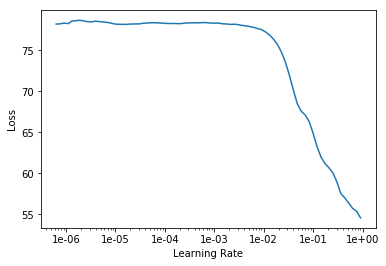

In [24]:
max_log_y = np.log(np.max(df['sales']))
y_range = torch.tensor([0, max_log_y*1.2], device=defaults.device)
learn = tabular_learner(data, layers=[200, 100], ps=[0.001, 0.01], emb_drop=0.04, metrics=exp_rmspe, y_range=None)
learn.lr_find()
learn.recorder.plot()

In [25]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=5, max_lr=1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,0.027814,0.003969,0.054542
2,0.014298,0.001768,0.038213
3,0.012103,0.002204,0.043714
4,0.011726,0.001904,0.040232
5,0.011184,0.002410,0.046476


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


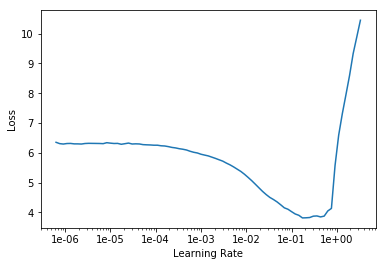

In [34]:
max_log_y = np.log(np.max(df['sales']))
y_range = torch.tensor([0, max_log_y*1.2], device=defaults.device)
learn = tabular_learner(data, layers=[200, 100], ps=[0.001, 0.01], emb_drop=0.04, metrics=exp_rmspe, y_range=y_range,
                        callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback,
                                              monitor='exp_rmspe', min_delta=0.01, patience=3)])
learn.lr_find()
learn.recorder.plot()

In [35]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=5, max_lr=1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,0.007617,0.003750,0.060596
2,0.005848,0.001397,0.033643
3,0.005116,0.000728,0.024775
4,0.005028,0.000680,0.024480


Epoch 5: early stopping


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


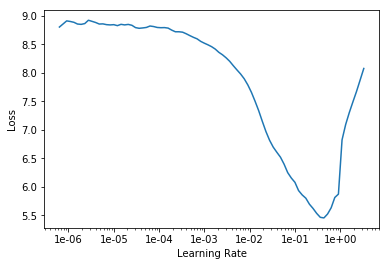

In [38]:
max_log_y = np.log(np.max(df['sales']))
y_range = torch.tensor([0, max_log_y*1.2], device=defaults.device)
learn = tabular_learner(data, layers=[200, 100], ps=[0.001, 0.01], emb_drop=0.04, metrics=exp_rmspe, y_range=y_range,
                        callback_fns=[partial(callbacks.tracker.TrackerCallback, monitor='exp_rmspe'),
                                      partial(callbacks.tracker.EarlyStoppingCallback,
                                              monitor='exp_rmspe', min_delta=0.01, patience=3),
                                      partial(callbacks.tracker.SaveModelCallback, monitor='exp_rmspe', mode='min',
                                              name='learn'+datetime.now().strftime("%Y-%m-%d-%Hh%Mm%Ss")+
                                              str(callbacks.tracker.TrackerCallback.get_monitor_value()))])

learn.lr_find()
learn.recorder.plot()

In [39]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=5, max_lr=1e-2)

epoch,train_loss,valid_loss,exp_rmspe
1,0.007780,0.010056,0.058114
2,0.010374,0.011523,0.112203
3,0.007024,0.005276,0.084764
4,0.005610,0.001683,0.039178
5,0.004452,0.001598,0.037631


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


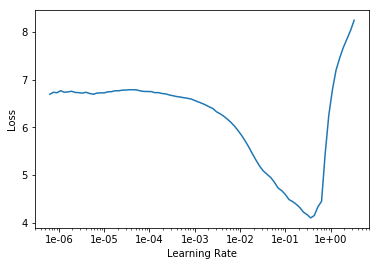

In [63]:
max_log_y = np.log(np.max(df['sales']))
y_range = torch.tensor([0, max_log_y*1.2], device=defaults.device)
#monitor = partial(callbacks.tracker.TrackerCallback, monitor='exp_rmspe')
learn = tabular_learner(data, layers=[200, 100], ps=[0.001, 0.01], emb_drop=0.04, metrics=exp_rmspe, y_range=y_range,
                        callback_fns=[partial(callbacks.tracker.TrackerCallback, monitor='exp_rmspe'),
                                      partial(callbacks.tracker.EarlyStoppingCallback,
                                              monitor='exp_rmspe', min_delta=0.01, patience=3),
                                      partial(callbacks.tracker.SaveModelCallback, monitor='exp_rmspe', mode='min',
                                              name='learn'+datetime.now().strftime("%Y-%m-%d-%Hh%Mm%Ss"))])#+
                                              #str(self.monitor.value))])

learn.lr_find()
learn.recorder.plot()

In [64]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=5, max_lr=1e-2)

epoch,train_loss,valid_loss,exp_rmspe
1,0.007840,0.001892,0.039926
2,0.007148,0.016561,0.136135
3,0.005926,0.015835,0.133028
4,0.005765,0.004485,0.064821
5,0.004398,0.004535,0.028856


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


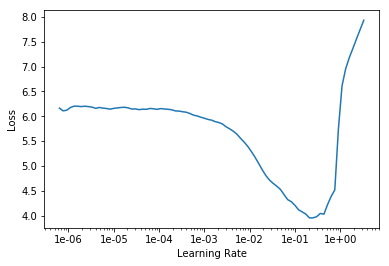

In [65]:
max_log_y = np.log(np.max(df['sales']))
y_range = torch.tensor([0, max_log_y*1.2], device=defaults.device)
learn = tabular_learner(data, layers=[200, 100], ps=[0.01, 0.1], emb_drop=0.01, metrics=exp_rmspe, y_range=y_range,
                        callback_fns=[partial(callbacks.tracker.TrackerCallback, monitor='exp_rmspe'),
                                      partial(callbacks.tracker.EarlyStoppingCallback,
                                              monitor='exp_rmspe', min_delta=0.01, patience=3),
                                      partial(callbacks.tracker.SaveModelCallback, monitor='exp_rmspe', mode='min',
                                              name='learn'+datetime.now().strftime("%Y-%m-%d-%Hh%Mm%Ss"))])

learn.lr_find()
learn.recorder.plot()

In [67]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=10, max_lr=1e-1)

epoch,train_loss,valid_loss,exp_rmspe
1,0.011991,0.030289,0.134892
2,0.024159,0.010915,0.106399
3,0.133778,0.113881,0.168107
4,0.247532,0.130170,0.443117
5,0.258647,0.104921,0.305293
6,0.019269,0.148513,0.351830
7,0.020047,0.185238,0.192497


Epoch 8: early stopping


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


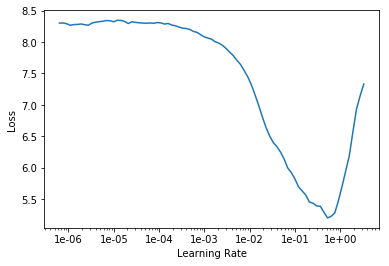

In [69]:
max_log_y = np.log(np.max(df['sales']))
y_range = torch.tensor([0, max_log_y*1.2], device=defaults.device)
learn = tabular_learner(data, layers=[200, 100], ps=[0.0001, 0.001], emb_drop=0.01, metrics=exp_rmspe, y_range=y_range,
                        callback_fns=[partial(callbacks.tracker.TrackerCallback, monitor='exp_rmspe'),
                                      partial(callbacks.tracker.EarlyStoppingCallback, mode='min',
                                              monitor='exp_rmspe', min_delta=0.01, patience=1),
                                      partial(callbacks.tracker.SaveModelCallback, #monitor='exp_rmspe', mode='min',
                                              every='epoch',
                                              name='learn'+datetime.now().strftime("%Y-%m-%d-%Hh%Mm%Ss"))])

learn.lr_find()
learn.recorder.plot()

In [70]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=10, max_lr=1e-1)

epoch,train_loss,valid_loss,exp_rmspe
1,0.012411,0.037185,0.078601
2,0.027517,0.049099,0.264565


Epoch 3: early stopping


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


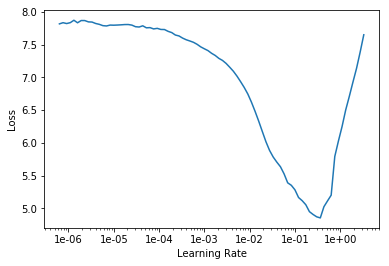

In [71]:
max_log_y = np.log(np.max(df['sales']))
y_range = torch.tensor([0, max_log_y*1.2], device=defaults.device)
learn = tabular_learner(data, layers=[200, 100], ps=[0.0001, 0.001], emb_drop=0.01, metrics=exp_rmspe, y_range=y_range,
                        callback_fns=[partial(callbacks.tracker.TrackerCallback, monitor='exp_rmspe'),
                                      partial(callbacks.tracker.EarlyStoppingCallback, mode='min',
                                              monitor='exp_rmspe', min_delta=0.01, patience=1),
                                      partial(callbacks.tracker.SaveModelCallback, #monitor='exp_rmspe', mode='min',
                                              every='epoch',
                                              name='learn'+datetime.now().strftime("%Y-%m-%d-%X"))])

learn.lr_find()
learn.recorder.plot()

In [72]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=10, max_lr=1e-2)

epoch,train_loss,valid_loss,exp_rmspe
1,0.008962,0.009186,0.098847
2,0.007365,0.062294,0.097346
3,0.007308,0.004800,0.078185
4,0.007758,0.005981,0.050448
5,0.005284,0.001948,0.039747
6,0.005581,0.003055,0.055234


Epoch 7: early stopping


In [137]:
#str(learn.metrics) # exp_rmspe
learn.validate() # [0.043663565, tensor(0.1885)]

#f = io.StringIO()
#with contextlib.redirect_stdout(f):
    #learn.show_results()
#print(f)

#with io.StringIO() as buf, contextlib.redirect_stdout(buf):
    #print('redirected')
    #learn.show_results()
    #output = buf.getvalue()
    #print('here is the stuff')
    #print(f.getvalue())
    #print(output)
#learn.show_results(rows=len(valid_idx))

'[<function exp_rmspe at 0x7f01bf7497b8>]'

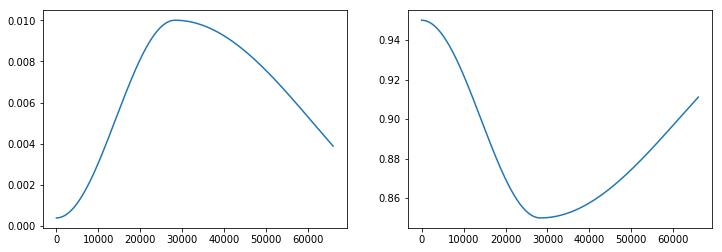

In [128]:
learn.recorder.plot_lr(show_moms=True)

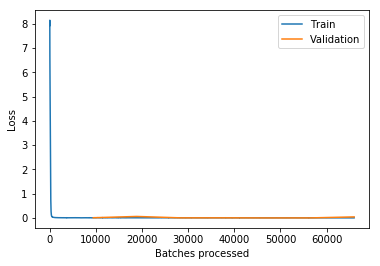

In [135]:
learn.recorder.plot_losses()

In [136]:
exp(0.043663565)

1.0446308453832427

,Predicted,Actual
0,6182.853027,7594.0
1,10538.260742,12579.0
2,3922.231201,4801.0
3,4591.333496,5678.0
4,3406.504395,4210.0
5,2384.660645,2794.0
6,3727.992676,4574.0
7,4030.333008,4971.0
8,8861.073242,10732.0
9,9005.706055,10868.0


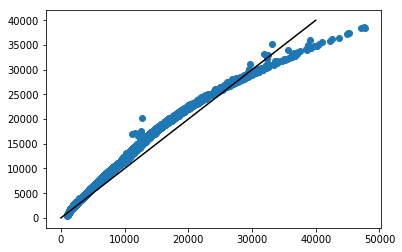

In [143]:
#preds, _ = learn.get_preds(ds_type=DatasetType.Valid)
labels = np.exp(preds.numpy())
validation_start = list(valid_idx)[0]
real = df[validation_start:].sales.values
sub = pd.DataFrame({'Predicted': labels[:,0], 'Actual': real})
fig, ax = plt.subplots()
ax.scatter(sub.Predicted, sub.Actual)
#ax.set_xlim([0,10000])
#ax.set_ylim([0,10000])
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')
sub.head(15)

,Predicted,Actual
0,6182.853027,7594.0
1,10538.260742,12579.0
2,3922.231201,4801.0
3,4591.333496,5678.0
4,3406.504395,4210.0
5,2384.660645,2794.0
6,3727.992676,4574.0
7,4030.333008,4971.0
8,8861.073242,10732.0
9,9005.706055,10868.0


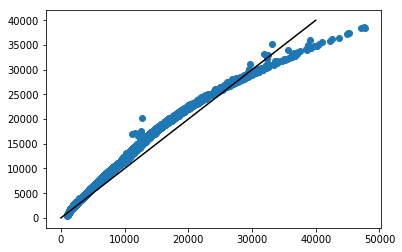

In [144]:
#train_preds, _ = learn.get_preds(ds_type=DatasetType.Train)
train_labels = np.exp(train_preds.numpy())
validation_start = list(valid_idx)[0]
train_real = df[:validation_start].sales.values
train_sub = pd.DataFrame({'Predicted': labels[:,0], 'Actual': real})
fig, ax = plt.subplots()
ax.scatter(train_sub.Predicted, train_sub.Actual)
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')
#ax.set_xlim([0,10000])
#ax.set_ylim([0,10000])
train_sub.head(15)

In [156]:
#path # PosixPath('../../data/interim')
#!pwd # /home/jupyter/Capstone-SalesForecasting/notebooks/models
!ls {path/'models'}

learn2019-02-21-17h46m25s0.0581.pth  learn2019-02-21-19h22m30s_2.pth
learn2019-02-21-18h14m58s0.0399.pth  learn2019-02-21-19h22m30s_3.pth
learn2019-02-21-18h51m57s.pth	     learn2019-02-21-19h22m30s_4.pth
learn2019-02-21-19h16m52s_1.pth      learn2019-02-21-19h22m30s_5_0.0397.pth
learn2019-02-21-19h16m52s_2.pth      learn2019-02-21-19h22m30s_6.pth
learn2019-02-21-19h16m52s_3.pth      learn2019-02-21-19h22m30s_7.pth
learn2019-02-21-19h22m30s_1.pth      tmp.pth


In [172]:
#check_df = pd.read_csv(f'{DATA_PATH}/train_valid_data.csv', low_memory=False)
#len(check_df) # 1003500
#check_df.date.max() # '2015-06-19'
1115*42 # 46830
check_df.sort_values('date').iloc[-46830:,:].date.min() #2015-05-09
pd.to_datetime('2015-06-19') - pd.to_timedelta('42 Days') # 2015-05-08
len(check_df[check_df.date >= ('2015-05-08')]) #47945
len(check_df[check_df.date >= ('2015-05-09')]) #46830
len(check_df[(check_df.date >= '2015-05-09') & (check_df.sales == 0)]) #9358

9358

In [159]:
saved = learn.load('learn2019-02-21-19h22m30s_5_0.0397')

saved_preds, _ = learn.get_preds(ds_type=DatasetType.Valid)
len(saved_preds)
#saved_labels = np.exp(saved_preds.numpy())
#validation_start = list(valid_idx)[0]
#real = df[:validation_start].sales.values
#saved_sub = pd.DataFrame({'Predicted': saved_labels[:,0], 'Actual': real})
#fig, ax = plt.subplots()
#ax.scatter(sub.Predicted, sub.Actual)
#ax.set_xlim([0,10000])
#ax.set_ylim([0,10000])
#ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')
#sub.head(15)

200700

In [175]:
test_df.head()

,store,state,max_temperature_c,mean_temperature_c,min_temperature_c,dew_point_c,mean_dew_point_c,min_dew_point_c,max_humidity,mean_humidity,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,HE,17,14,11,9,7,5,88,64,...,20,5,171,False,False,False,False,False,False,1434758400
1,56,HE,17,14,11,9,7,5,88,64,...,20,5,171,False,False,False,False,False,False,1434758400
2,69,HE,17,14,11,9,7,5,88,64,...,20,5,171,False,False,False,False,False,False,1434758400
3,77,HE,17,14,11,9,7,5,88,64,...,20,5,171,False,False,False,False,False,False,1434758400
4,111,HE,17,14,11,9,7,5,88,64,...,20,5,171,False,False,False,False,False,False,1434758400


In [177]:
# Following the outline of https://docs.fast.ai/data_block.html#Add-a-test-set
# to add a test set and see how it compares
dep_var = 'sales'

check_test_df = df.append(test_df)
check_test_df = check_test_df[check_test_df.sales != 0]
test_valid_idx = range(len(check_test_df)-len(test_df), len(check_test_df))

test_data = (TabularList.from_df(check_test_df, path=DATA_PATH, cat_names=cat_names, cont_names=cont_names, procs=procs)
                   .split_by_idx(test_valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   .databunch())

learn.validate(test_data.valid_dl)

RuntimeError: reduce failed to synchronize: device-side assert triggered

# Starting over from the top

In [174]:
DATA_PATH = Path('../../data/interim')
path = Path('../../models/')

In [202]:
# Import train_valid_data and test_data dataframes
train_valid_df_raw = pd.read_csv(DATA_PATH/'train_valid_data.csv', low_memory=False)
test_df_raw = pd.read_csv(DATA_PATH/'test_data.csv', low_memory=False)

train_valid_df = train_valid_df_raw.copy()
test_df = test_df_raw.copy()

# Drop week_start as that will get taken into account by add_datepart() for date
train_valid_df.drop('week_start', axis='columns', inplace=True)
test_df.drop('week_start', axis='columns', inplace=True)

# Drop any rows where sales = 0 since we don't need to forecast those
train_valid_df = train_valid_df[train_valid_df.sales != 0]

# Run tabular.add_datepart() on both dfs to add columns about the date: ['Year', 'Month', 'Week', 'Day', 'Dayofweek',
# 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
tabular.add_datepart(train_valid_df, 'date', drop=True, time=False)
tabular.add_datepart(test_df, 'date', drop=True, time=False)

# Category names, to which we'll apply embeddings
cat_names = ['assortment', 'events', 'promo_interval', 'state', 'state_holiday', 'store_type']

# Add the date-related categories
cat_names += ['Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
              'Is_year_start', 'Month', 'Week', 'Year',]

# Continuous-variable names, which we'll make sure are all represented as floats
# Just use set difference to make sure everything is covered
cont_names = list(set(train_valid_df.columns) - set(cat_names))

# Set up transforms to 1) replace missing values for continuous variables by the median column value, 2) transform all
# categorical variables into categories, 3) normalize continuous variables.
# Note that FillMissing should do nothing since we shouldn't have any NaNs -- leaving it in anyway
procs = [FillMissing, Categorify, Normalize]

df = train_valid_df

# Feed zeros for sales to the model to be sure we're not cheating
test_df['sales'] = 0.0

# Validation set is 
valid_idx = range(int(0.8 * len(df)), len(df))
dep_var = 'sales'
print(valid_idx)
print(len(df))

data = (TabularList.from_df(df, path=DATA_PATH, cat_names=cat_names, cont_names=cont_names, procs=procs)
                   #.split_by_idx(valid_idx)
                   .no_split()
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   #.add_test(test_df)
                   .databunch())

data.show_batch()

range(643244, 804056)
804056


RuntimeError: CUDA error: device-side assert triggered

In [ ]:
max_log_y = np.log(np.max(df['sales']))
y_range = torch.tensor([0, max_log_y*1.2], device=defaults.device)
learn = tabular_learner(data, layers=[200, 100], ps=[0.0001, 0.001], emb_drop=0.01, metrics=exp_rmspe, y_range=y_range,
                        callback_fns=[partial(callbacks.tracker.TrackerCallback, monitor='exp_rmspe'),
                                      partial(callbacks.tracker.EarlyStoppingCallback, mode='min',
                                              monitor='exp_rmspe', min_delta=0.01, patience=1),
                                      partial(callbacks.tracker.SaveModelCallback, #monitor='exp_rmspe', mode='min',
                                              every='epoch',
                                              name='learn'+datetime.now().strftime("%Y-%m-%d-%X"))])

learn.lr_find()
learn.recorder.plot()

In [ ]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=10, max_lr=1e-2)